# MlFlow Experiment Tracking Setup

In [1]:
import mlflow
mlflow.autolog()
mlflow.set_tracking_uri("http://localhost:8080")
mlflow.set_experiment("Efficient_Net_Unfreeze")
mlflow.set_tag("mlflow.runName", "Efficient_Net_Unfreeze_version_1")
mlflow.set_experiment_tag

<function mlflow.tracking.fluent.set_experiment_tag(key: str, value: Any) -> None>

# Imports

In [2]:
import os
import cv2
import sys
from PIL import Image
from torchvision.transforms.functional import to_pil_image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split, Subset
#Using Resnet50 for classification
import torchvision.models as models
import torch.nn as nn
from torchmetrics import Accuracy, Precision, Recall, F1Score
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
import torch.optim as optim
import numpy as np

MAIN_DIR = Path("__file__").resolve().parent.parent.parent
CLASSIFICATION_MAPPING_DIR = os.path.join(MAIN_DIR, "classification_mapping") 
if CLASSIFICATION_MAPPING_DIR not in sys.path:
    sys.path.insert(0, CLASSIFICATION_MAPPING_DIR)
from classification_mapping import CLASSIFICATION_MAPPING

DATA_DIR = os.path.join(MAIN_DIR, 'data')
TRANSLATED_DATA_DIR = os.path.join(MAIN_DIR, 'data_translated_Efficient_Net')

2025/06/25 14:31:42 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [3]:
DEVICE = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cuda device


# Loading Dataset

In [4]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

In [5]:
# Function to transform images to 224x224 for ResNet with normalization based on
# original model image normalization settings
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [6]:
def transformed_image(image_path:str) -> torch.tensor:
    image = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)
    image_tensor = transform(img_pil)
    return image_tensor

In [7]:
data, labels = [], []

# Reconverting the image to view in data_translated
mean = torch.tensor(mean).view(3, 1, 1)
std = torch.tensor(std).view(3, 1, 1)

for dir_ in os.listdir(DATA_DIR):
    path = os.path.join(DATA_DIR, dir_)
    translated_path = os.path.join(TRANSLATED_DATA_DIR, dir_)
    if not os.path.exists(translated_path): os.makedirs(translated_path)

    for img in os.listdir(path):
        # Load and transform the image
        image_tensor = transformed_image(os.path.join(path, img))
        data.append(image_tensor)
        labels.append(dir_)

        # Convert back to PIL image, unnormalize, and save
        unnormalized = image_tensor * std + mean
        unnormalized = unnormalized.clamp(0, 1)
        
        image_pil = to_pil_image(unnormalized)
        image_translated_path = os.path.join(translated_path, img)
        image_pil.save(image_translated_path)

In [8]:
print(len(data))

178


In [9]:
class SignDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = torch.tensor([CLASSIFICATION_MAPPING[label] for label in labels], dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    @property
    def classes(self):
        return self.data.classes

In [10]:
dataset = SignDataset(data, labels)
len(dataset)

178

In [11]:
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
print(len(train_dataset))
print(len(test_dataset))

143
35


In [12]:
train_dataloader = DataLoader(dataset, batch_size = 16, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle = True)

In [13]:
for data, label in train_dataloader:
    print(data.shape)
    print(label.shape)
    break

torch.Size([16, 3, 300, 300])
torch.Size([16])


# Function to Load Pre-trained Model from Pytorch

In [14]:
def create_model():
    # Load EfficientNet-B3 with pretrained weights
    model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)
    num_classes = 4

    # UnFreeze all parameters
    for param in model.parameters():
        param.requires_grad = True

    # Replace the last layer (classifier[1]) to match num_classes
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    # Unfreeze just the new classifier layer
    for param in model.classifier[1].parameters():
        param.requires_grad = True

    return model

In [15]:
# Add checkpoint to model
from torch.utils.checkpoint import checkpoint_sequential
class EfficientNetCheckpointed(nn.Module):
    def __init__(self, model, num_segments=8):  # You can tune this
        super().__init__()
        self.stem = model.features[0]  # First block (usually Conv + BN + SiLU)
        
        # Wrap remaining blocks in Sequential to use checkpoint_sequential
        self.blocks = nn.Sequential(*model.features[1:])
        
        self.num_segments = num_segments  # for checkpointing
        self.avgpool = model.avgpool
        self.classifier = model.classifier

    def forward(self, x):
        x = self.stem(x)
        
        # Apply checkpointing across MBConv blocks
        x = checkpoint_sequential(self.blocks, self.num_segments, x, use_reentrant=False)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [16]:
model = EfficientNetCheckpointed(model = create_model()).to(DEVICE)
model.to(DEVICE)

EfficientNetCheckpointed(
  (stem): Conv2dNormActivation(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAc

In [17]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# Model training

In [18]:
num_epochs = 100
train_losses, val_losses = [], []
train_accuracy, val_accuracy = [], [] 
train_accuracy_obj = Accuracy(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)
validation_accuracy_obj = Accuracy(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)

In [19]:
for epoch in range(num_epochs):
    model.train() #setting model mode .train or .eval
    running_loss = 0.0
    train_accuracy_obj.reset()

    # its not acutally each image here but a batch of images instead (batch size = 16 so 16 images)
    for image_batch, label_batch in tqdm(train_dataloader, desc = "Training loop"):
        images, labels = image_batch.to(DEVICE), label_batch.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images) # logits output
        # logits output can work directly with labels
        loss = criterion(outputs, labels)
        # logits output can work directly with labels
        # Accuracy work by identifying the dimensions between outputs and labels
        # If same dimension -> labels to labels. If diff dimensions -> Logits to Labels
        train_accuracy_obj.update(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(train_loss)
    train_acc = train_accuracy_obj.compute().item()
    train_accuracy.append(train_acc)

    #Validation phase
    model.eval()
    running_loss = 0.0
    validation_accuracy_obj.reset()
    with torch.no_grad():
        for image_batch, label_batch in tqdm(test_dataloader, desc = "Validation loop"):
            images, labels = image_batch.to(DEVICE), label_batch.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            validation_accuracy_obj.update(outputs, labels)
    val_loss = running_loss / len(test_dataloader.dataset)
    val_acc = validation_accuracy_obj.compute().item()
    val_losses.append(val_loss)
    val_accuracy.append(val_acc)
    

    print("Epoch %d out of %s - Train loss: %s , Validation loss: %s , Train accuracy: %s , Validation accuracy: %s " % (epoch + 1, 
                                                                                                                         num_epochs, 
                                                                                                                         train_loss, 
                                                                                                                         val_loss,
                                                                                                                         train_acc,
                                                                                                                         val_acc))

Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 out of 100 - Train loss: 1.3816774333460946 , Validation loss: 1.2354780776160104 , Train accuracy: 0.27467644214630127 , Validation accuracy: 0.7819444537162781 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2 out of 100 - Train loss: 1.1704958529954546 , Validation loss: 1.0598933798926218 , Train accuracy: 0.7204831838607788 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3 out of 100 - Train loss: 1.0280845995699421 , Validation loss: 0.8569135103906904 , Train accuracy: 0.8571674823760986 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4 out of 100 - Train loss: 0.8347370557570726 , Validation loss: 0.6225369998386928 , Train accuracy: 0.9098418354988098 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5 out of 100 - Train loss: 0.6419308640983667 , Validation loss: 0.42826548985072543 , Train accuracy: 0.9607484936714172 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6 out of 100 - Train loss: 0.45001556096452006 , Validation loss: 0.26219066466603963 , Train accuracy: 0.9815818071365356 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7 out of 100 - Train loss: 0.33509573106015667 , Validation loss: 0.1504187499838216 , Train accuracy: 0.9814910888671875 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8 out of 100 - Train loss: 0.20845918508058184 , Validation loss: 0.0826538811836924 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9 out of 100 - Train loss: 0.1680705694670088 , Validation loss: 0.05031261295080185 , Train accuracy: 0.9856675863265991 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10 out of 100 - Train loss: 0.15902463673205858 , Validation loss: 0.029240995539086205 , Train accuracy: 0.9695513248443604 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11 out of 100 - Train loss: 0.10185855158259359 , Validation loss: 0.026282517399106708 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12 out of 100 - Train loss: 0.07204627270778913 , Validation loss: 0.017782052287033626 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13 out of 100 - Train loss: 0.08057614273569558 , Validation loss: 0.013728376504565988 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14 out of 100 - Train loss: 0.059377051806182 , Validation loss: 0.00880261209926435 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15 out of 100 - Train loss: 0.0348892245399818 , Validation loss: 0.007359896107975925 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16 out of 100 - Train loss: 0.026511062983046757 , Validation loss: 0.007389804188694273 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17 out of 100 - Train loss: 0.04243076140626093 , Validation loss: 0.0059936903017972195 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18 out of 100 - Train loss: 0.04894924624247497 , Validation loss: 0.004189195603664432 , Train accuracy: 0.990384578704834 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19 out of 100 - Train loss: 0.03350039956609854 , Validation loss: 0.004694147687405348 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20 out of 100 - Train loss: 0.05158855807915162 , Validation loss: 0.0036040193201707944 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21 out of 100 - Train loss: 0.022802225994260125 , Validation loss: 0.0033293427234249457 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22 out of 100 - Train loss: 0.07443230507079135 , Validation loss: 0.0028195694088935853 , Train accuracy: 0.970295786857605 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23 out of 100 - Train loss: 0.053236181816358245 , Validation loss: 0.003454513555126531 , Train accuracy: 0.9905660152435303 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24 out of 100 - Train loss: 0.04401798876986075 , Validation loss: 0.003117246852655496 , Train accuracy: 0.990384578704834 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25 out of 100 - Train loss: 0.049922968648122935 , Validation loss: 0.003414352876799447 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26 out of 100 - Train loss: 0.02468660088737359 , Validation loss: 0.0024175990372896196 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27 out of 100 - Train loss: 0.037285442348946346 , Validation loss: 0.0020029198178755387 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28 out of 100 - Train loss: 0.02022686663470911 , Validation loss: 0.002100054547190666 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29 out of 100 - Train loss: 0.027756624216778894 , Validation loss: 0.0018449891092521804 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30 out of 100 - Train loss: 0.03450643369572216 , Validation loss: 0.002584440354257822 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31 out of 100 - Train loss: 0.049254126909576104 , Validation loss: 0.00231022972480527 , Train accuracy: 0.9884355664253235 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32 out of 100 - Train loss: 0.029471085396375548 , Validation loss: 0.0029914544695722207 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33 out of 100 - Train loss: 0.03088700922017687 , Validation loss: 0.0038862215687653846 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34 out of 100 - Train loss: 0.04517880925552899 , Validation loss: 0.0018049045100009867 , Train accuracy: 0.990384578704834 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 35 out of 100 - Train loss: 0.026782189527254426 , Validation loss: 0.0020590513412441524 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 36 out of 100 - Train loss: 0.02031625254770343 , Validation loss: 0.0013628790121791618 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 37 out of 100 - Train loss: 0.028475623494118786 , Validation loss: 0.0009632521475266133 , Train accuracy: 0.9930555820465088 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 38 out of 100 - Train loss: 0.01421871329291483 , Validation loss: 0.0012476611549832992 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 39 out of 100 - Train loss: 0.020401004346066648 , Validation loss: 0.0010174524554583642 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 40 out of 100 - Train loss: 0.02854249862891235 , Validation loss: 0.0008439423167146742 , Train accuracy: 0.9864864945411682 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 41 out of 100 - Train loss: 0.020530970662497403 , Validation loss: 0.0010804033522228045 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 42 out of 100 - Train loss: 0.026328554774603146 , Validation loss: 0.0006685628339515201 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 43 out of 100 - Train loss: 0.03002435908642378 , Validation loss: 0.000793349215694304 , Train accuracy: 0.990384578704834 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 44 out of 100 - Train loss: 0.034502748462758706 , Validation loss: 0.0007069062691048852 , Train accuracy: 0.9861111044883728 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 45 out of 100 - Train loss: 0.025109608458836426 , Validation loss: 0.0011655656388029456 , Train accuracy: 0.9930555820465088 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 46 out of 100 - Train loss: 0.03526723058371062 , Validation loss: 0.001408493601983147 , Train accuracy: 0.9795420169830322 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 47 out of 100 - Train loss: 0.01054440007618304 , Validation loss: 0.0014774674150560584 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 48 out of 100 - Train loss: 0.03409257263280033 , Validation loss: 0.0013164238555223814 , Train accuracy: 0.9837185740470886 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 49 out of 100 - Train loss: 0.0322025553480293 , Validation loss: 0.0015813446470669338 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 50 out of 100 - Train loss: 0.03024460222530231 , Validation loss: 0.0011439224904669183 , Train accuracy: 0.9885262250900269 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 51 out of 100 - Train loss: 0.02971079907892795 , Validation loss: 0.0013291335772789483 , Train accuracy: 0.9930555820465088 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 52 out of 100 - Train loss: 0.014855461885754982 , Validation loss: 0.0010582697145374758 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 53 out of 100 - Train loss: 0.012111947651994363 , Validation loss: 0.0010285685869998165 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 54 out of 100 - Train loss: 0.019048825241206737 , Validation loss: 0.0007197183423808643 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 55 out of 100 - Train loss: 0.012099310483657913 , Validation loss: 0.0006938990438356996 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 56 out of 100 - Train loss: 0.010348921924243483 , Validation loss: 0.0004893590953932809 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 57 out of 100 - Train loss: 0.03324310269123048 , Validation loss: 0.0003755835799633392 , Train accuracy: 0.9795420169830322 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 58 out of 100 - Train loss: 0.010454680519492438 , Validation loss: 0.0007261302322149277 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 59 out of 100 - Train loss: 0.012093187634194836 , Validation loss: 0.0006551928585395217 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 60 out of 100 - Train loss: 0.017300181640207433 , Validation loss: 0.00042283829118657326 , Train accuracy: 0.995192289352417 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 61 out of 100 - Train loss: 0.011016112898758958 , Validation loss: 0.0026408077313265364 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 62 out of 100 - Train loss: 0.009400225966499092 , Validation loss: 0.0018746437870764306 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 63 out of 100 - Train loss: 0.020148367976790732 , Validation loss: 0.0005887737864603488 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 64 out of 100 - Train loss: 0.012349032482990388 , Validation loss: 0.0004572315124927887 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 65 out of 100 - Train loss: 0.012426483559976803 , Validation loss: 0.0005455755162984133 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 66 out of 100 - Train loss: 0.011584492463074374 , Validation loss: 0.0004071345236817641 , Train accuracy: 0.9930555820465088 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 67 out of 100 - Train loss: 0.021994797178031354 , Validation loss: 0.00030448494425010204 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 68 out of 100 - Train loss: 0.024313696503136934 , Validation loss: 0.000638919576470341 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 69 out of 100 - Train loss: 0.026037618413232686 , Validation loss: 0.00047441681422891895 , Train accuracy: 0.9905660152435303 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 70 out of 100 - Train loss: 0.03316343911620003 , Validation loss: 0.0004759177989659033 , Train accuracy: 0.995192289352417 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 71 out of 100 - Train loss: 0.02917526164249088 , Validation loss: 0.0007526237367918449 , Train accuracy: 0.995192289352417 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 72 out of 100 - Train loss: 0.029546317215381045 , Validation loss: 0.0004780415058901001 , Train accuracy: 0.9904752969741821 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 73 out of 100 - Train loss: 0.020195689753451374 , Validation loss: 0.00047882339651031153 , Train accuracy: 0.995192289352417 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 74 out of 100 - Train loss: 0.010599755901801452 , Validation loss: 0.0006588937290611544 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 75 out of 100 - Train loss: 0.009947679120670544 , Validation loss: 0.0005823691254980597 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 76 out of 100 - Train loss: 0.01516480143234301 , Validation loss: 0.0005523145855737052 , Train accuracy: 0.9930555820465088 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 77 out of 100 - Train loss: 0.0062498769649628845 , Validation loss: 0.0003600179359117257 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 78 out of 100 - Train loss: 0.010252195902252466 , Validation loss: 0.00036978591233491895 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 79 out of 100 - Train loss: 0.00846908666360914 , Validation loss: 0.00031682799204385705 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 80 out of 100 - Train loss: 0.0102852412520416 , Validation loss: 0.0003499549248122743 , Train accuracy: 0.995192289352417 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 81 out of 100 - Train loss: 0.05070776102038917 , Validation loss: 0.00033912090584635733 , Train accuracy: 0.9932432174682617 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 82 out of 100 - Train loss: 0.017448348181552432 , Validation loss: 0.0010858838117980797 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 83 out of 100 - Train loss: 0.022579966468757456 , Validation loss: 0.0006700046027877501 , Train accuracy: 0.995192289352417 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 84 out of 100 - Train loss: 0.012403827997740735 , Validation loss: 0.0012098325216876608 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 85 out of 100 - Train loss: 0.032493505061844764 , Validation loss: 0.0008331394920657788 , Train accuracy: 0.995192289352417 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 86 out of 100 - Train loss: 0.02321645731545901 , Validation loss: 0.0005804195293291871 , Train accuracy: 0.9930555820465088 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 87 out of 100 - Train loss: 0.025846367419352024 , Validation loss: 0.000413847023238694 , Train accuracy: 0.9885262250900269 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 88 out of 100 - Train loss: 0.008277899868200335 , Validation loss: 0.0013302298029884696 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 89 out of 100 - Train loss: 0.01188197046560183 , Validation loss: 0.0009646614531188139 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 90 out of 100 - Train loss: 0.006829261654213573 , Validation loss: 0.0007060497633314558 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 91 out of 100 - Train loss: 0.016971244361628307 , Validation loss: 0.0009906402934575453 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 92 out of 100 - Train loss: 0.017586431016078156 , Validation loss: 0.0007566083792231178 , Train accuracy: 0.9930555820465088 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 93 out of 100 - Train loss: 0.012292703843853447 , Validation loss: 0.00105390199127474 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 94 out of 100 - Train loss: 0.010706216797986057 , Validation loss: 0.000996201006429536 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 95 out of 100 - Train loss: 0.015560987818818749 , Validation loss: 0.0006439367893368139 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 96 out of 100 - Train loss: 0.031409741745571075 , Validation loss: 0.0009958046721294522 , Train accuracy: 0.9930555820465088 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 97 out of 100 - Train loss: 0.00392926764789592 , Validation loss: 0.0008015558256634644 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 98 out of 100 - Train loss: 0.008589954549718774 , Validation loss: 0.0006321698294154235 , Train accuracy: 1.0 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 99 out of 100 - Train loss: 0.03056255593016911 , Validation loss: 0.0004689868387816075 , Train accuracy: 0.9952830076217651 , Validation accuracy: 1.0 


Training loop:   0%|          | 0/12 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 100 out of 100 - Train loss: 0.00853930910777175 , Validation loss: 0.002709284092166594 , Train accuracy: 1.0 , Validation accuracy: 1.0 


# Visualize

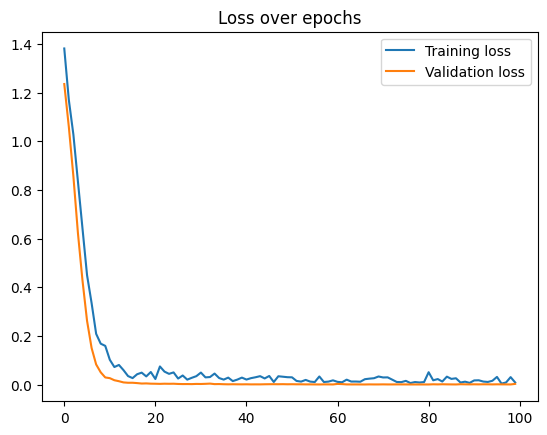

In [20]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

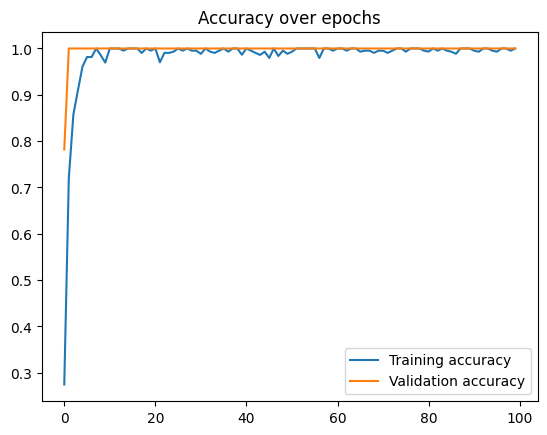

In [21]:
plt.plot(train_accuracy, label='Training accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

# Test Model with Seperated Test Data

In [22]:
#TEST_FOLDER_DIR = os.path.join(os.path.dirname(MAIN_DIR), "test_data")
TEST_FOLDER_DIR = os.path.join(MAIN_DIR, "test_data")
test_data, test_labels = [], []

for dir_ in os.listdir(TEST_FOLDER_DIR):
    path = os.path.join(TEST_FOLDER_DIR, dir_)

    for img in os.listdir(path):
        image_tensor = transformed_image(os.path.join(path, img))
        test_data.append(image_tensor)
        test_labels.append(dir_)


In [23]:
test_dataset = SignDataset(test_data, test_labels)
len(test_dataset)
test_dataloader = DataLoader(test_dataset, batch_size = len(test_dataset))

for data, label in test_dataloader:
    print(data.shape)
    print(label.shape)
    break

torch.Size([35, 3, 300, 300])
torch.Size([35])


In [24]:
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        for image_batch, label_batch in tqdm(test_dataloader, desc = "Validation loop"):
            images, labels = image_batch.to(DEVICE), label_batch.to(DEVICE)
            outputs = model(images)
            return outputs, labels

In [25]:
predicted, ground_truth = predict(model, test_dataloader)

accuracy = Accuracy(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)
precision = Precision(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)
recall = Recall(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)
f1score = F1Score(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro').to(DEVICE)

accuracy.update(predicted, ground_truth)
precision.update(predicted, ground_truth)
recall.update(predicted, ground_truth)
f1score.update(predicted, ground_truth)

Validation loop:   0%|          | 0/1 [00:00<?, ?it/s]

In [26]:
# Compute and print results
print("Accuracy:", accuracy.compute())
print("Precision:", precision.compute())
print("Recall:", recall.compute())
print("F1 Score:", f1score.compute())

Accuracy: tensor(0.8810, device='cuda:0')
Precision: tensor(0.8854, device='cuda:0')
Recall: tensor(0.8810, device='cuda:0')
F1 Score: tensor(0.8787, device='cuda:0')


# Logging with MlFlow 

In [27]:
# Log parameters 
mlflow.log_param("optimizer", "Adam")
mlflow.log_param("learning_rate", 0.0001)
mlflow.log_param("weight_decay", 0.0001)
mlflow.log_param("loss_function", "CrossEntropyLoss")
mlflow.log_param("epoch", 100)
mlflow.log_param("traing_batch_size", 16)
mlflow.log_param("validation_batch_size", 16)

16

In [28]:
# Log result
mlflow.log_metric("train_loss", train_loss)
mlflow.log_metric("train_accuracy", train_acc)
mlflow.log_metric("validation_loss", val_loss)
mlflow.log_metric("validation_accuracy", val_acc)
mlflow.log_metric("test_accuracy", accuracy.compute())
mlflow.log_metric("test_precision", precision.compute())
mlflow.log_metric("test_recall", recall.compute())
mlflow.log_metric("test_f1", f1score.compute())

In [29]:
# Log dataset
mlflow.log_artifacts(DATA_DIR, artifact_path="dataset")
mlflow.log_artifacts(TEST_FOLDER_DIR, artifact_path="test_dataset")

In [30]:
# Log model
mlflow.pytorch.log_model(artifact_path="EfficientNet_Unfreeze", pytorch_model=model, registered_model_name="EfficientNet_Unfreeze")

2025/06/25 14:36:23 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/25 14:36:32 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.22.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.22.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/25 14:36:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'EfficientNet_Unfreez